# Distribution of the lengths of the protein coding genes 
**for the different species**

## [Log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)
It is a continuous probability distribution of a random variable whose logarithm is normally distributed. For human-readability the decimal logarithm (log10) is used.
  
**The PDF (Probability Density Function) of a normal distribution is**  
$ f(x) = \frac{1}{ \sigma \sqrt{2 \pi}} e^- \frac{1}{2} {(\frac{(x-\mu)}{\sigma})}^{2} $

## Import python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os 
import pandas as pd
import math

## The protein coding gene length distributions for the different species

### Retrieving the statistical descriptions of the gene length's distributions and the taxonomy ids

#### Statistical description 

In [2]:
# statistics on length distribution for different species     
stat_file = "../main_tables/stat_protCodGenes.tsv"
print("The statistical descriptions of the protein coding gene distributions for the different species is in:\n", stat_file, "\n")

# retrieve data and diminish the number of columns
stat_df = pd.read_csv(stat_file, low_memory=False, sep="\t")
stat_df = stat_df[["division_8", "species", "trunk_genes_path", "genes_file", "count", "mean", "var"] + ["log10_mean", "log10_var"]]

# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(stat_df.head(2))
    print(stat_df.shape)

The statistical descriptions of the protein coding gene distributions for the different species is in:
 ../main_tables/stat_protCodGenes.tsv 



,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var
0,archaea,methanobacterium_bryantii_gca_002287175,ftp.ensemblgenomes.org/pub/bacteria/release-49...,protein_coding.genes.methanobacterium_bryantii...,3168,840.404040,422343.848699,2.827684,0.082694
1,archaea,methanobacterium_formicicum_gca_000762265,ftp.ensemblgenomes.org/pub/bacteria/release-49...,protein_coding.genes.methanobacterium_formicic...,2352,862.427296,347239.612747,2.849723,0.076317


(33629, 9)


#### Taxonomy id for each species from Ensembl

In [3]:
# ENSEMBL tax_id     
ensembl_taxId_file = "../main_tables/extra_tables/species_Ensembl.tsv" 

# retrieve data
taxid_df = pd.read_csv(ensembl_taxId_file, sep="\t")
taxid_df = taxid_df[["#name", "species", "taxonomy_id"]]
taxid_df.rename(columns = {"#name" : 'name', "taxonomy_id" : 'tax_id'}, inplace = True)

# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(taxid_df.head(2))
    print(taxid_df.shape)

,name,species,tax_id
0,Spiny chromis,acanthochromis_polyacanthus,80966
1,Panda,ailuropoda_melanoleuca,9646


(33021, 3)


In [4]:
# Use pandas.merge() on multiple columns
stat_taxid_df = pd.merge(stat_df, taxid_df, on=['species'])
stat_taxid_df = stat_taxid_df[stat_taxid_df['tax_id'].notna()]
if 0:
    display(stat_taxid_df.head(2))
    print(stat_taxid_df.shape)

## Python functions

In [5]:
# species' stats for length distribution
def get_df_for_taxid(df, taxid):
     return df.loc[df["tax_id"]==taxid].copy()

In [6]:
#### Function to plot the log-normal distribution
# blue: Observation
# red: Theoretical/Simulation
##########################################
def plot_log_norm (log10_len, mu, sigma, N, title, subtitle, xlabel, ylabel): # N is number of 
    print("µ:", mu, "\tσ:", sigma)
    my_normal_dist = np.random.normal(mu, sigma, N)
    count, bins, *rest = plt.hist(log10_len, 60, density=True, alpha=0.8, edgecolor='black') # plot 60 bins

    # plt.hist(my_normal_dist, 30, density=True, alpha=0.25, color="r")
    # print(count); print(bins); print(*rest)
    
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
             np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
             linewidth=2, color='r', alpha=0.5)
     
    # mean
    plt.vlines(x = mu, ymin = 0, ymax = 0.2, colors = 'white', label = 'mean')
    plt.xlim([1,7]); plt.ylim([0,2.0])
    plt.suptitle(title, style='italic'); plt.title(subtitle + " (" + str(int(N)) +")")
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()

In [7]:
def does_it_fits_normal(data_observed): 
    # Kurtosis and Skewness
    # =====================
    print('Kurtosis:', stats.kurtosis(data_observed))
    print('Skewness:', stats.skew(data_observed))
    # D'Agostino's K-squared test
    # ===========================
    k2, p_value = stats.normaltest(data_observed)
    print(f"D'Agostino's K-squared test(statistics={k2}, p-value={p_value})")
    #
    # Mathematicaly it ends up beeing a theoretical log-normal when.
    #    - Kurtosis o Skewness: $\leq -1$ o $\geq 1$ 
    #    - D'Agostino's K-squared test: p-value $ \leq 0.05 $, becuase it rejects the null hypothesis 

In [8]:
# The next function performs the whole analysis for a tax_id
def species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id):
    species_df = get_df_for_taxid(stat_taxid_df, tax_id)
    species_df.drop_duplicates(subset=['tax_id'], inplace=True, keep='last')
    display(species_df)
    
    # system dependencies
    system = list(os.uname())[0]
    if system == 'Linux':
        our_mnt_dir = "/media/emuro/Nubya/" # my disks: Nubya, Wes
    elif system == 'Darwin':
        our_mnt_dir = "/Volumes/Wes/" # my disks: Wes, Nubya 
    genes_f = our_mnt_dir + "results/geneLength/" + species_df["trunk_genes_path"].item() + species_df["genes_file"].item()    
    # retrieve data
    genes_df = pd.read_csv(genes_f, sep="\t")

    # visualize data
    pd.set_option('display.max_columns', None)
    if 0:
        display(genes_df.head(2))
        print(genes_df.shape)
    
    # plot the distributions: observed and theoretical
    genes_df["log10_length"] = genes_df["length"].apply(np.log10)
    title = species_df["species"].item().capitalize(); subtitle = "Protein coding genes";  xlabel = "$log_{10}(length)$"; ylabel = "Probability density function"
    plot_log_norm (genes_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), species_df["count"].item(), 
                   title, subtitle, xlabel, ylabel)  
    # fit to normal
    does_it_fits_normal(genes_df["log10_length"])

## Distributions for different species:

### _Homo sapiens_ (tax_id = 9606)

#### Retrieve its statistical description

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
33298,vertebrates,homo_sapiens,ftp.ensembl.org/pub/release-98/genes/homo_sapi...,protein_coding.genes.homo_sapiens.nan.ensembl....,19976,68287.089808,1.753600e+10,4.40396,0.415191,Human,9606


µ: 4.40396048586088 	σ: 0.644352861905651


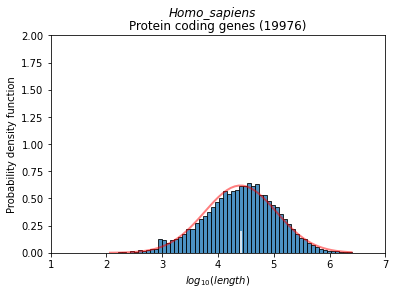

Kurtosis: -0.1116735171105625
Skewness: -0.19274087219104544
D'Agostino's K-squared test(statistics=133.03487000453904, p-value=1.293734108353449e-29)


In [9]:
tax_id = 9606
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)

## Fig. 1

### _Danio rerio_ (tax_id = 7955)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
33248,vertebrates,danio_rerio,ftp.ensembl.org/pub/release-98/genes/danio_rerio/,protein_coding.genes.danio_rerio.nan.ensembl.9...,25432,31084.050802,2.666395e+09,4.137251,0.330834,Zebrafish,7955


µ: 4.1372512074567 	σ: 0.5751817206250265


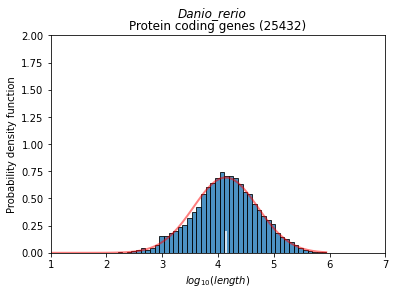

Kurtosis: 0.13464961203755843
Skewness: -0.15265070017727597
D'Agostino's K-squared test(statistics=114.79272415546741, p-value=1.1832504227909413e-25)


In [10]:
tax_id = 7955
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)

## Fig S1

### _Acanthochromis polyacanthus_ (tax_id = 80966)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
33419,vertebrates,acanthochromis_polyacanthus,ftp.ensembl.org/pub/release-98/genes/acanthoch...,protein_coding.genes.acanthochromis_polyacanth...,24016,17577.741964,7.636914e+08,3.93983,0.283414,Spiny chromis,80966


µ: 3.93982998775739 	σ: 0.5323666774485448


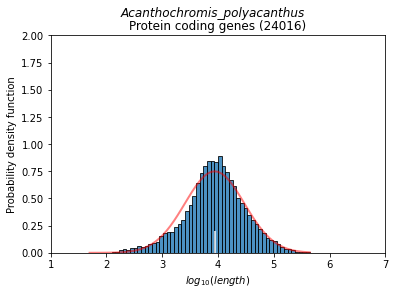

Kurtosis: 0.42030888797885346
Skewness: -0.2579638939752618
D'Agostino's K-squared test(statistics=380.77633533999034, p-value=2.0676135100958134e-83)


In [11]:
tax_id = 80966
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)

### _Apteryx owenii_ (tax_id = 8824)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
33272,vertebrates,apteryx_owenii,ftp.ensembl.org/pub/release-98/genes/apteryx_o...,protein_coding.genes.apteryx_owenii.nan.ensemb...,16196,27013.371635,1.942660e+09,4.061432,0.349542,Little spotted kiwi,8824


µ: 4.06143212159683 	σ: 0.5912211118722343


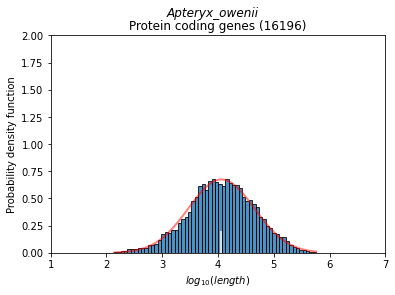

Kurtosis: -0.10656389889003348
Skewness: -0.13692417062331863
D'Agostino's K-squared test(statistics=58.58800417183088, p-value=1.895730254744762e-13)


In [12]:
tax_id = 8824
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)

### _Equus asinus asinus_ (tax_id = 83772)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
33421,vertebrates,equus_asinus_asinus,ftp.ensembl.org/pub/release-98/genes/equus_asi...,protein_coding.genes.equus_asinus_asinus.nan.e...,19922,38350.468879,5.261993e+09,4.080104,0.506864,Donkey,83772


µ: 4.08010374287238 	σ: 0.7119438680979533


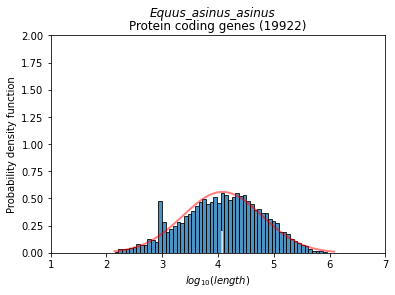

Kurtosis: -0.4968881798624136
Skewness: -0.1308309001466365
D'Agostino's K-squared test(statistics=430.974640559165, p-value=2.6004342800239943e-94)


In [13]:
tax_id = 83772
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)

### _Vitis vinifera_ (tax\_id = 29760)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
32959,plants,vitis_vinifera,ftp.ensemblgenomes.org/pub/plants/release-49/g...,protein_coding.genes.vitis_vinifera.plants.ens...,29927,5130.068032,5.891958e+07,3.424509,0.257295,Vitis vinifera,29760


µ: 3.42450856444256 	σ: 0.5072424656357845


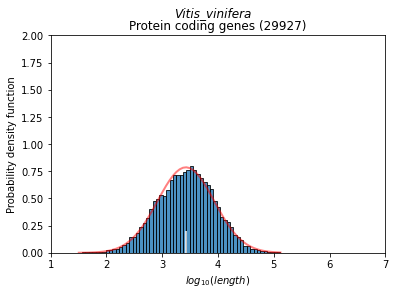

Kurtosis: -0.11615923649822468
Skewness: -0.06492750869776981
D'Agostino's K-squared test(statistics=39.80747144130329, p-value=2.2694332172693754e-09)


In [14]:
tax_id = 29760
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)

### _Acinetobacter baumannii_ (tax\_id = 1310800)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
20848,bacteria,acinetobacter_baumannii_1000160_gca_000588715,ftp.ensemblgenomes.org/pub/bacteria/release-49...,protein_coding.genes.acinetobacter_baumannii_1...,3793,907.272607,511523.644547,2.854921,0.0964,Acinetobacter sp. 1000160 (GCA_000588715),1310800


µ: 2.85492133432345 	σ: 0.31048337590178643


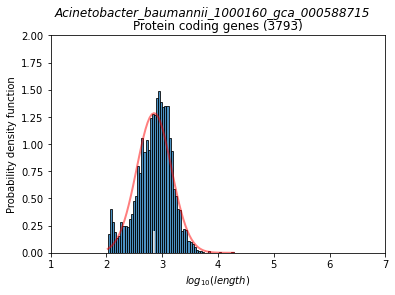

Kurtosis: 0.25388735879414215
Skewness: -0.39567316500472893
D'Agostino's K-squared test(statistics=100.92079482259223, p-value=1.217104448112482e-22)


In [15]:
tax_id = 1310800
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)

### _Colletotrichum gloeosporioides_ (tax\_id = 1213859)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
32436,fungi,colletotrichum_gloeosporioides,ftp.ensemblgenomes.org/pub/fungi/release-49/ge...,protein_coding.genes.colletotrichum_gloeospori...,15381,1577.847994,1.301188e+06,3.113453,0.072943,Colletotrichum gloeosporioides,1213859


µ: 3.11345279442653 	σ: 0.270079763960005


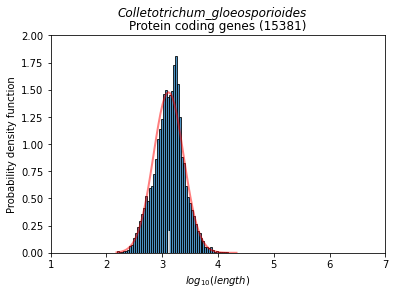

Kurtosis: 0.29151251785412935
Skewness: -0.024260748353795065
D'Agostino's K-squared test(statistics=43.685576070336786, p-value=3.264357289389213e-10)


In [16]:
tax_id = 1213859
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)

## Fig S2

### _Cavia porcellus_ (tax\_id = 10141)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
33356,vertebrates,cavia_porcellus,ftp.ensembl.org/pub/release-98/genes/cavia_por...,protein_coding.genes.cavia_porcellus.nan.ensem...,18095,44419.205195,8.237268e+09,4.175953,0.469809,Guinea Pig,10141


µ: 4.17595294995147 	σ: 0.6854262938675558


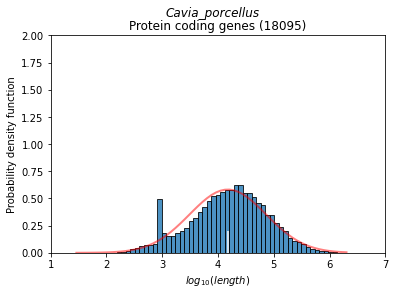

Kurtosis: -0.27267797775275016
Skewness: -0.21905949768800043
D'Agostino's K-squared test(statistics=216.8373902747619, p-value=8.210298872993568e-48)


In [17]:
tax_id = 10141
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)

## Fig S7

### _Shewanella loihica_ (tax\_id = 323850)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
13643,bacteria,shewanella_loihica_pv_4_gca_000016065,ftp.ensemblgenomes.org/pub/bacteria/release-49...,protein_coding.genes.shewanella_loihica_pv_4_g...,3859,1021.363307,545351.060302,2.91913,0.078996,Shewanella loihica PV-4 (GCA_000016065),323850


µ: 2.91912954750495 	σ: 0.2810616140768444


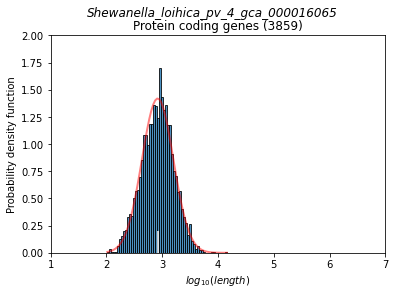

Kurtosis: -0.0928872982845288
Skewness: -0.04449234391593719
D'Agostino's K-squared test(statistics=2.6687314757122547, p-value=0.2633251396685134)


In [18]:
tax_id = 323850
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)

### _Orchesella cincta_ (tax\_id = 48709)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
32867,metazoa,orchesella_cincta,ftp.ensemblgenomes.org/pub/metazoa/release-49/...,protein_coding.genes.orchesella_cincta.metazoa...,20247,2989.466094,1.212137e+07,3.312794,0.13434,Orchesella cincta,48709


µ: 3.31279370368112 	σ: 0.36652388139624


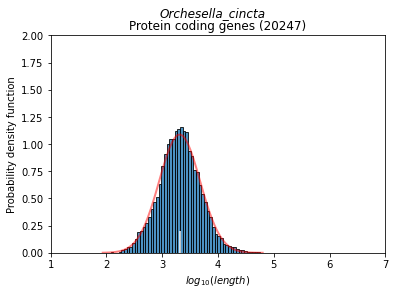

Kurtosis: 0.28192068320907726
Skewness: 0.11965997379018041
D'Agostino's K-squared test(statistics=100.23131466136556, p-value=1.7180925883051545e-22)


In [19]:
tax_id = 48709
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)